In [1]:
import os
import sys

project_path = os.path.join( os.getcwd(), '../../../../')
sys.path.append(project_path)
print(project_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

/data/ephemeral/home/mlops-cloud-project-mlops_1/modeling/src/airflow/notebooks/../../../../


In [2]:
temperature_df = pd.read_csv(os.path.join(project_path, 'data/TA_data.csv'))
temperature_df_train = temperature_df[-365*5:-365].reset_index(drop=True)
temperature_df_inference = temperature_df[-365:].reset_index(drop=True)
temperature_df = temperature_df_train

In [3]:
temperature_df.shape

(1460, 4)

In [4]:
temperature_df.head(1)

,날짜,TA_AVG,TA_MAX,TA_MIN
0,2020-05-29,20.7,27.6,14.6


In [5]:
temperature_columns = ['TA_AVG', 'TA_MAX', 'TA_MIN']

In [6]:
temperature_df_timestamp = temperature_df[['날짜']].copy()
temperature_df_timestamp.rename(columns={'날짜': 'datetime'}, inplace=True)
temperature_df = temperature_df[temperature_columns]

In [7]:
temperature_df_timestamp.head(1)

,datetime
0,2020-05-29


In [8]:
temperature_df.head(1)

,TA_AVG,TA_MAX,TA_MIN
0,20.7,27.6,14.6


In [9]:
train_prp = 0.6
train = temperature_df.iloc[:int(temperature_df.shape[0]*train_prp)]
test = temperature_df.iloc[int(temperature_df.shape[0]*train_prp):]

In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(f"train shape : {X_train.shape}, test shape : {X_test.shape}")

train shape : (876, 1, 3), test shape : (584, 1, 3)


In [11]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42, shuffle=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [13]:
class AnomalyDetectorLSTM(nn.Module):
    def __init__(self, seq_len, n_features):
        super(AnomalyDetectorLSTM, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = 4

        self.encoder = nn.Sequential(
            nn.LSTM(input_size=n_features, hidden_size=16, batch_first=True),
            nn.LSTM(input_size=16, hidden_size=self.embedding_dim, batch_first=True)
        )

        self.decoder = nn.Sequential(
            nn.LSTM(input_size=self.embedding_dim, hidden_size=self.embedding_dim, batch_first=True),
            nn.LSTM(input_size=self.embedding_dim, hidden_size=16, batch_first=True),
            nn.Linear(16, n_features)
        )

    def forward(self, x):
        # Encode
        x, _ = self.encoder[0](x)
        x, (hidden, _) = self.encoder[1](x)

        # Repeat vector
        x = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)

        # Decode
        x, _ = self.decoder[0](x)
        x, _ = self.decoder[1](x)
        x = self.decoder[2](x)
        return x

In [14]:
epochs = 10
batch_size = 10
learning_rate = 1e-3

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=batch_size, shuffle=False)

model = AnomalyDetectorLSTM(seq_len=X_train.shape[1], n_features=X_train.shape[2])
model.to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_epoch_loss = 0
    for batch in train_loader:
        batch = batch[0]
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    
    avg_train_loss = train_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = batch[0]
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch [1/10] | Train Loss: 0.5956 | Val Loss: 0.5200
Epoch [2/10] | Train Loss: 0.3121 | Val Loss: 0.1424
Epoch [3/10] | Train Loss: 0.1462 | Val Loss: 0.1281
Epoch [4/10] | Train Loss: 0.1387 | Val Loss: 0.1191
Epoch [5/10] | Train Loss: 0.1118 | Val Loss: 0.0774
Epoch [6/10] | Train Loss: 0.0715 | Val Loss: 0.0546
Epoch [7/10] | Train Loss: 0.0517 | Val Loss: 0.0399
Epoch [8/10] | Train Loss: 0.0312 | Val Loss: 0.0273
Epoch [9/10] | Train Loss: 0.0245 | Val Loss: 0.0261
Epoch [10/10] | Train Loss: 0.0228 | Val Loss: 0.0247


In [15]:
model_path = os.path.join(project_path, f"models/lstm_temperature_anomaly_detector.pth")
torch.save(model.state_dict(), model_path)

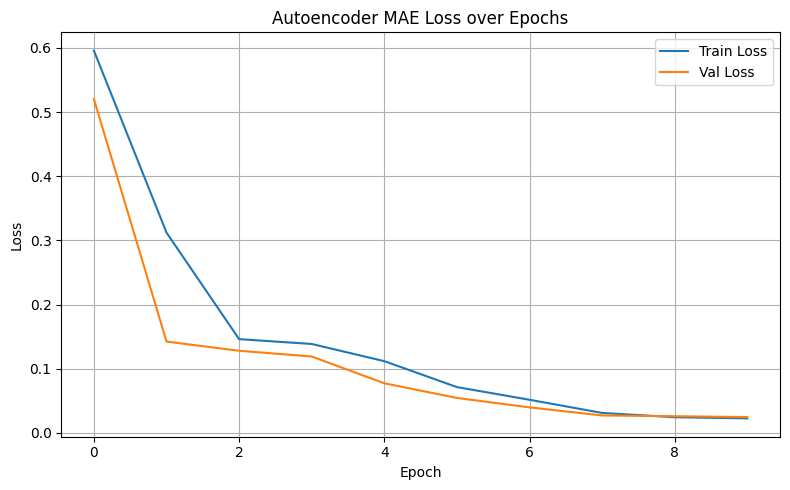

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Autoencoder MAE Loss over Epochs")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(project_path, f"data/outputs/train/temperature_Error_Loss.png"))

In [17]:
with torch.no_grad():
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_tensor = X_tensor.to(device)
    X_pred = model(X_tensor).detach().cpu().numpy()

X_pred = X_pred[:, -1, :]
X_pred_inv = scaler.inverse_transform(X_pred)
pred_df = pd.DataFrame(X_pred_inv, columns=temperature_df.columns)

scores = pd.DataFrame()

for column in temperature_columns:
    scores[f"{column}_train"] = temperature_df[column].values[:len(pred_df)]
    scores[f"{column}_predicted"] = pred_df[column]
    scores[f"{column}_loss_mae"] = (scores[f"{column}_train"] - scores[f"{column}_predicted"]).abs()

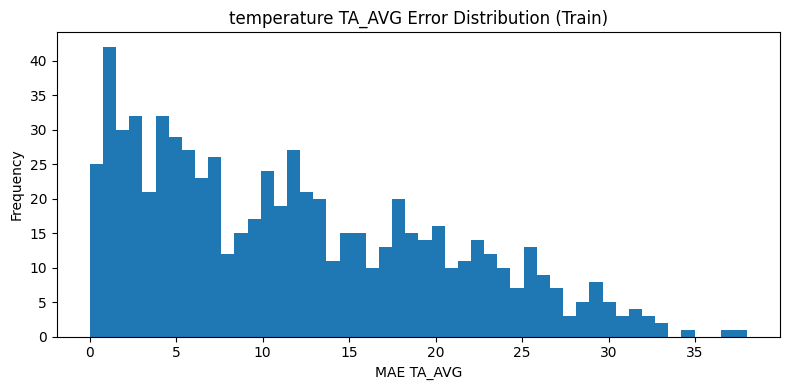

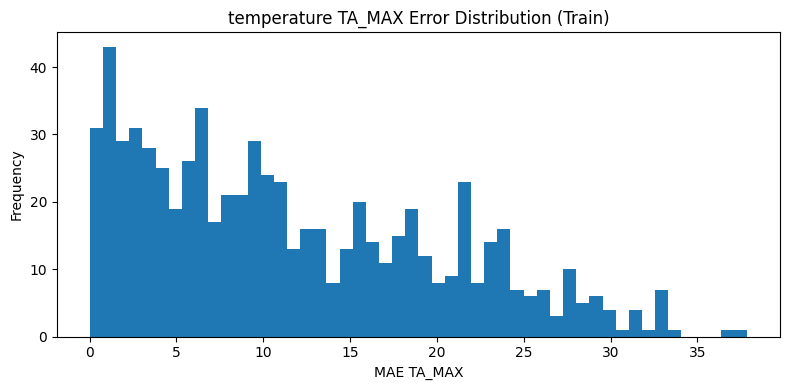

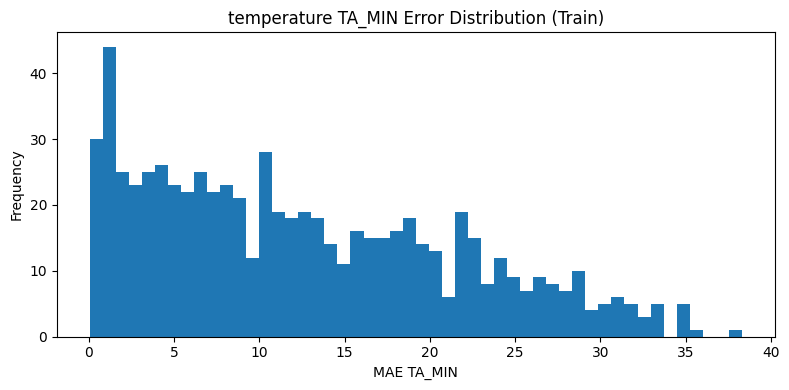

In [18]:
for column in temperature_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(scores[f"{column}_loss_mae"], bins=50)
    plt.title(f"temperature {column} Error Distribution (Train)")
    plt.xlabel(f"MAE {column}")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(project_path, f"data/outputs/train/temperature_{column}_Error_Distribution.png"))

In [19]:
with torch.no_grad():
    X_tensor = torch.tensor(X_test, dtype=torch.float32)
    X_tensor = X_tensor.to(device)
    X_pred = model(X_tensor).detach().cpu().numpy()

X_pred = X_pred[:, -1, :]
X_pred_inv = scaler.inverse_transform(X_pred)
X_pred_df = pd.DataFrame(X_pred_inv, columns=temperature_df.columns)
X_pred_df.index = test.index

In [20]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
import pandas as pd

output_dir = os.path.join(project_path, "data/outputs/train")
os.makedirs(output_dir, exist_ok=True)

for column in temperature_columns:
    scores = X_pred_df.copy()

    scores['datetime'] = pd.to_datetime(temperature_df_timestamp.loc[scores.index, 'datetime'], errors='coerce')
    scores['real'] = test[column].values
    scores['loss_mae'] = np.abs(scores['real'] - scores[column])
    scores['Threshold'] = 10
    scores['Anomaly'] = (scores['loss_mae'] > scores['Threshold']).astype(int)
    scores['anomalies'] = np.where(scores['Anomaly'] == 1, scores['real'], np.nan)

    scores = scores.sort_values(by='datetime').reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(scores['datetime'], scores['loss_mae'], label='Loss')
    ax.plot(scores['datetime'], scores['Threshold'], label='Threshold', linestyle='--')

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    ax.set_title("Loss vs Threshold")
    ax.set_xlabel("Datetime")
    ax.set_ylabel("Loss")
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"temperature_{column}_Threshold.png"))
    plt.close()

    cols = ['datetime'] + [col for col in scores.columns if col != 'datetime']
    scores = scores[cols]
    scores[scores["Anomaly"] == 1].to_csv(
        os.path.join(output_dir, f"temperature_{column}_anomalies.csv"),
        index=False
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(scores['datetime'], scores['real'], label=column)

    if scores['Anomaly'].sum() > 0:
        mask = scores['Anomaly'] == 1
        ax.scatter(scores.loc[mask, 'datetime'], scores.loc[mask, 'anomalies'],
                   color='red', label='Anomaly', s=25)

    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    ax.set_title("Anomalies Detected (Test)")
    ax.set_xlabel("Datetime")
    ax.set_ylabel(column)
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"temperature_{column}_Anomaly.png"))
    plt.close()
